# Summarization of Amazon Musical Instruments Reviews Using Deep Learning (LSTM)

In this notebook, I will summarize Amazon Musical Instrument Reviews using a deep learning abstractive based method in Keras.

Frequently, customer reviews are long and complex text data. When we are talking about large e-commerce like Amazon, it is an impossible task to perform the analysis on customer reviews manually. That is where the Natural Language Processing shines. Using state-of-the-art deep learning methods we can efficiently summarize the customer reviews and have cleaner data to work on tasks like a sentimental analysis.

Also, we are going to compare the performance of the summarizer with the summary provided by the dataset.

We will be working on a dataset that you can find in Kaggle (https://www.kaggle.com/eswarchandt/amazon-music-reviews).

## Loading Packages

In [1]:
import re
import warnings
import os

import numpy as np
import pandas as pd 

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import contractions
import string

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
%matplotlib inline

from sklearn.model_selection import train_test_split

from attention import AttentionLayer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Read the dataset

This dataset consists of reviews of Musical Instruments from Amazon. 

The Dataset contains reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time

Description of columns in the file:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [23]:
df=pd.read_csv("../data/Musical_instruments_reviews.csv")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [25]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so ...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the sc...",5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequen...",5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoi...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Drop Duplicates and NA values

In [26]:
df.drop_duplicates(subset=['reviewText'],inplace=True)#dropping duplicates
df.dropna(subset=['reviewText'],axis=0,inplace=True)#dropping na

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10254 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10254 non-null  object 
 1   asin            10254 non-null  object 
 2   reviewerName    10227 non-null  object 
 3   helpful         10254 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10254 non-null  float64
 6   summary         10254 non-null  object 
 7   unixReviewTime  10254 non-null  int64  
 8   reviewTime      10254 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 801.1+ KB


In [28]:
for i in range(9):
    print(df['reviewText'][i])

Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,
The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]
The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or hi

## Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

### 1. Cleaning the data

We will perform the below preprocessing tasks for our data:

    I. Convert everything to lowercase

    II. Expanding Contraction

    III. Remove punctuation and special characters

    IV. Remove stopwords

Let’s define the function:

In [44]:
sw = stopwords.words('english')

def clean_text(text):
    text = contractions.fix(text)      
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in sw])
    return text

Applying the function to the Body Text

In [45]:
cleanReviewText = df['reviewText'].apply(lambda x: clean_text(x))

Let's have a look at the first cleaned and tokenized review text

In [46]:
cleanReviewText[0]

'much write exactly supposed filters pop sounds recordings much crisp one lowest prices pop filters amazon might well buy honestly work despite pricing'

Applying the function to the Summary Text

In [47]:
cleanSummary = df['summary'].apply(lambda x: clean_text(x))

Let's have a look at the first cleaned and tokenized review summary text

In [48]:
cleanSummary[0]

'good'

In [49]:
df['cleanReviewText']=cleanReviewText
df['cleanSummary']=cleanSummary

In [50]:
df['cleanSummary']

0                                                good
1                                                jake
2                                            job well
3                               good windscreen money
4                                  pops record vocals
                             ...                     
10256                                      five stars
10257          long life players good economic choice
10258                                     good coated
10259                                     taylor made
10260    strings really quite good would call perfect
Name: cleanSummary, Length: 10254, dtype: object

Remove empty rows

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10254 entries, 0 to 10260
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviewerID       10254 non-null  object 
 1   asin             10254 non-null  object 
 2   reviewerName     10227 non-null  object 
 3   helpful          10254 non-null  object 
 4   reviewText       10254 non-null  object 
 5   overall          10254 non-null  float64
 6   summary          10254 non-null  object 
 7   unixReviewTime   10254 non-null  int64  
 8   reviewTime       10254 non-null  object 
 9   cleanReviewText  10254 non-null  object 
 10  cleanSummary     10254 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.3+ MB


Splitting the Data into Train (90%) and Test (10%) sets

### Identify Avg. `Review` & `Summary` Lengths for Trimming 

['good']

In [81]:
split_text(np.array(df['cleanReviewText'][0]))

TypeError: 'Series' object is not callable

In [75]:
df['cleanReviewText'].apply(lambda x: split_text(x))

TypeError: 'Series' object is not callable

In [108]:
splitdf = pd.DataFrame()
splitdf['review'] = [text.split() for text in df['cleanReviewText']]
splitdf['summary'] = [text.split() for text in df['cleanSummary']]
review_lengths = splitdf['review'].apply(len)
summary_lengths = splitdf['summary'].apply(len)

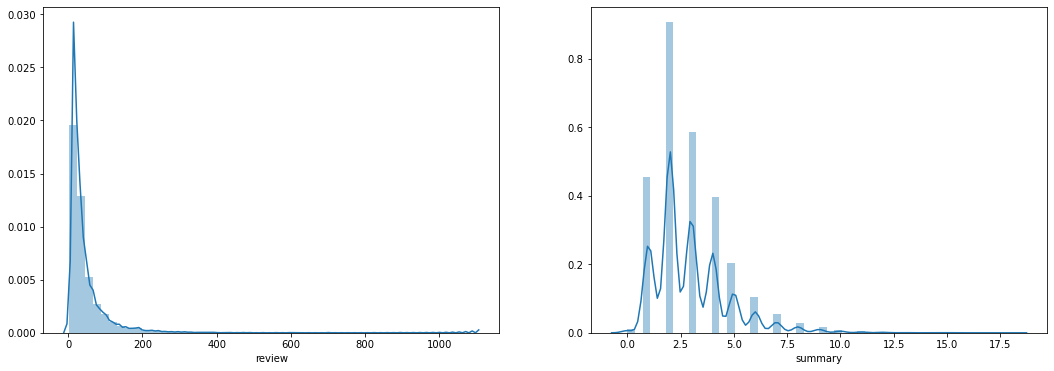

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(review_lengths, ax=ax[0])
sns.distplot(summary_lengths, ax=ax[1])
fig.show()

In [110]:
print(f'median review length is: {int(review_lengths.median())} words')
print(f'median summary length is: {int(summary_lengths.median())} words')

median review length is: 26 words
median summary length is: 3 words


In [111]:
cleanSummary[10]

'one best instrument cables within brand'

In [112]:
count_review = 0
count_summary = 0

for i in review_lengths:
    if(i <= 100):
        count_review += 1

for i in summary_lengths:
    if(i <= 8):
        count_summary += 1

print(f'Proportion of Reviews under 100 words in length: {round(count_review / len(df), 2)}')
print(f'Proportion of Summary under 8 words in length: {round(count_summary / len(df), 2)}')

Proportion of Reviews under 100 words in length: 0.91
Proportion of Summary under 8 words in length: 0.99


In [113]:
max_review_len = 100
max_summary_len = 8

## Identifying and Removing Rare Words

### 1. Body Text

Let's investigate the occurence of Rare Words in a sentence and remove them.

In [114]:
df['cleanSummary'] = df['cleanSummary'].apply(lambda x : 'sostok '+ x + ' eostok') # Adding start and end tokens to the summaries

In [115]:
X_train,X_test,y_train,y_test = train_test_split(df['cleanReviewText'],df['cleanSummary'],test_size=0.1,random_state=5,shuffle=True) 

In [116]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers

In [117]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [118]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in tokenizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 76.32699979714653
Total Coverage of rare words: 7.002904762705634


Removing Rare Words from the Tokenizer

In [119]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
Xtokenizer = Tokenizer(num_words=total_count-count) 
Xtokenizer.fit_on_texts(X_train)

# Fit the tokenizer to X_train and X_text data
X_train_seq    =   Xtokenizer.texts_to_sequences(X_train) 
X_test_seq   =   Xtokenizer.texts_to_sequences(X_test)

#padding zero up to maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen=max_review_len, padding='post')
X_test   =   pad_sequences(X_test_seq, maxlen=max_review_len, padding='post')

#size of vocabulary ( +1 for padding token)
X_vocabulary   =  Xtokenizer.num_words + 1

In [120]:
X_vocabulary

7003

### 2. Summary

In this section we investigate the occurence of rare words in the Summary Text and remove them from the vocabulary. Here we consider words that occurr less than 4 times as Rare

In [121]:
tokenizer = Tokenizer()   
tokenizer.fit_on_texts(list(y_train))

In [122]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in tokenizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 76.3430498675018
Total Coverage of rare words: 9.489880666171263


Let us define the tokenizer with top most common words for summary.

In [123]:
#prepare a tokenizer for reviews on training data
Ytokenizer = Tokenizer(num_words=total_count-count) 
Ytokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_seq    =   Ytokenizer.texts_to_sequences(y_train) 
y_test_seq   =   Ytokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_vocabulary  =   Ytokenizer.num_words +1

In [124]:
y_vocabulary

983

In [126]:
Ytokenizer.word_counts['sostok'],len(y_train)

(9228, 9228)

## Model building

In [127]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_review_len,))

#embedding layer
enc_emb =  Embedding(X_vocabulary, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_vocabulary, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     700300      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

To overcome any eventual memory issues, we are going to use sparse categorical cross-entropy as loss function to convert the integer sequence to a one-hot vector on the fly. 

In [128]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

I am monitoring the validation loss (val_loss) to early stopping the model. Our model will stop training once the validation loss increases.

In [129]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [130]:
history=model.fit([X_train,y_train[:,:-1]], 
                  y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
                  epochs=50,callbacks=[es],batch_size=64, 
                  validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Train on 9228 samples, validate on 1026 samples
Epoch 1/50
9228/9228 [==============================] - 780s 85ms/sample - loss: 2.4688 - val_loss: 2.1056
Epoch 2/50
9228/9228 [==============================] - 903s 98ms/sample - loss: 2.1718 - val_loss: 2.0468
Epoch 3/50
9228/9228 [==============================] - 938s 102ms/sample - loss: 2.1046 - val_loss: 2.0025
Epoch 4/50
9228/9228 [==============================] - 944s 102ms/sample - loss: 2.0617 - val_loss: 1.9977
Epoch 5/50
9228/9228 [==============================] - 942s 102ms/sample - loss: 2.0278 - val_loss: 1.9674
Epoch 6/50
9228/9228 [==============================] - 941s 102ms/sample - loss: 1.9945 - val_loss: 1.9423
Epoch 7/50
9228/9228 [==============================] - 944s 102ms/sample - loss: 1.9574 - val_loss: 1.9266
Epoch 8/50
9228/9228 [==============================] - 945s 102ms/sample - loss: 1.9219 - val_loss: 1.9012
Epoch 9/50
9228/9228 [==============================] - 947s 103ms/sample - loss: 1.8856 -

### Diagnostic Plot


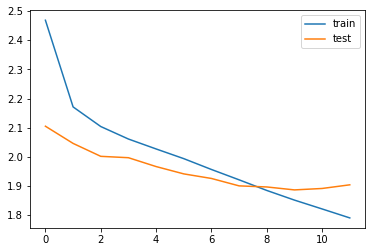

In [131]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [132]:
reverse_target_word_index=Ytokenizer.index_word
reverse_source_word_index=Xtokenizer.index_word
target_word_index=Ytokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [134]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_review_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [135]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [136]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [139]:
for i in range(0,100):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_review_len)))
    print("\n")

Review: really remarkable microphone around 100 sensitive studio live performances sure set daw insert input channel easily blow volume clipping rich warm tone like tube mics compares audio tech 2020 class say audio tech beat price 
Original summary: good quality mic price 
Predicted summary:  great value


Review: 3rd set cables ordered amazon needed lengthy cable requirement ordered one finish bad outer layer coated zinc alloy body works fine mixer previous set cables totally 4 cables one develop kind problem months exactly spot guess inner strings somehow gets broken stops working would see goes update review one also would result condition would look something better reason ordered ones pricing expensive replace 
Original summary: cable 
Predicted summary:  great cable


Review: cleaned polished pretty taylor guitar pretty well would recommend one least buy kind protect investment 
Original summary: seems work well 
Predicted summary:  great


Review: cables good complaint connecto